In [1]:
# import packages needed
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import cv2
import imutils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class shape:
    def __init__(self, points, index, area, center):
        self.points, self.index, self.area, self.center = points, index, area, center

def coordsToMedian(img, coords):
    hValues = []
    for i in coords:
        hValues.append(img[i[0],i[1]])
    hValues = np.array(hValues)
    return np.median(hValues[0:,0:1])
        
def findHSVColorRange(img, shapeArr, shapeIndex, kernel=3, outlierS=15):
#     try:
    _blur_img = cv2.GaussianBlur(img, (kernel,kernel), 0)
    _hsvImg = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    hH, sH, vH = 0, 0, 0
    hL, sL, vL = 255, 255, 255
    for x in shapeArr:
        if x.index == shapeIndex:
            x.points = np.array(x.points)
            hMedian = coordsToMedian(_hsvImg, x.points)
            for i in x.points:
                #watch for outliers
                j = _hsvImg[i[0]][i[1]]
                if j[0] in range(int(hMedian-outlierS), int(hMedian+outlierS)):
                    hH = j[0] if hH < j[0] else hH
                    hL = j[0] if hL > j[0] else hL
                    sH = j[1] if sH < j[1] else sH
                    sL = j[1] if sL > j[1] else sL
                    vH = j[2] if vH < j[2] else vH
                    vL = j[2] if vL > j[2] else vL
    rng = (np.array([hL, sL, vL]), np.array([hH, sH, vH]))
    print("lowerRange = np.array([%s, %s, %s])" % (hL, sL, vL))
    print("upperRange = np.array([%s, %s, %s])" % (hH, sH, vH))
#     except:
#         print("Input invalid")
    return rng

def locateShapes(img, min_area_size, kernel=3, _lowerThresh=127, _upperThresh=255, output_text=True, debug=False):
    _img = mpimg.imread(img)
    _arr = []
    _image = _img.copy()
    
    _blur_img = cv2.GaussianBlur(_image, (kernel,kernel), 0)
    _hsv_img  = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    
    imgray = cv2.cvtColor(_hsv_img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, _lowerThresh, _upperThresh, 0)
    
    _contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _contours = imutils.grab_contours(_contours)
       
    i = 0
    
    for _c in _contours:
        _M = cv2.moments(_c)
        _area = cv2.contourArea(_c)
        
        try:
            _cX = int((_M["m10"] / _M["m00"]))
            _cY = int((_M["m01"] / _M["m00"]))
        except:
            _cX, _cY = 0, 0
            
        if (_area >= min_area_size):  
            _coords = []
            
            if debug:
                print("Index: ", str(i), "area: ", _area, "center: (", _cX,",", _cY,")")
                
            cv2.drawContours(_image, [_c], -1, (0, 255, 0), 2)
            
            shapedImg = cv2.fillPoly(np.zeros(_image.shape[0]*_image.shape[1]*3).reshape(_image.shape[0],_image.shape[1],3), [_c], color=(255,255,255))
            values = np.where(shapedImg == np.array([255,255,255]))
            _coord = 0
            while _coord < len(values[0]):
                _coords.append([int(values[0][_coord]), int(values[1][_coord])])
                _coord+=3
            
            _arr.append(shape(_coords, i, _area, (_cX, _cY)))
    
            if output_text:
                cv2.putText(_image, str(i), (_cX-10, _cY+10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5)
            i+=1
    return _image, np.array(_arr)

def testRange(image, colorRange, kernel, min_area_size):
    _image = image.copy()
    _lower_color_hsv = colorRange[0]
    _upper_color_hsv = colorRange[1]
        
    _blur_img = cv2.GaussianBlur(_image, (kernel,kernel), 0)
    _hsv_img  = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    
    _mask_img = cv2.inRange(_hsv_img, _lower_color_hsv, _upper_color_hsv)

    _contours = cv2.findContours(_mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _contours = imutils.grab_contours(_contours)
    
    for _c in _contours:
        
        _M = cv2.moments(_c)
        _area = cv2.contourArea(_c)
        
        try:
            _cX = int((_M["m10"] / _M["m00"]))
            _cY = int((_M["m01"] / _M["m00"]))
        except:
            _cX = 0
            _cY = 0
            
        if (_area >= min_area_size):
            
            cv2.drawContours(_image, [_c], -1, (0, 255, 0), 2)

            cv2.circle(_image,(_cX, _cY), 6, (255, 0, 0), -1)
    
    return _image

lowerRange = np.array([92, 163, 50])
upperRange = np.array([98, 251, 229])


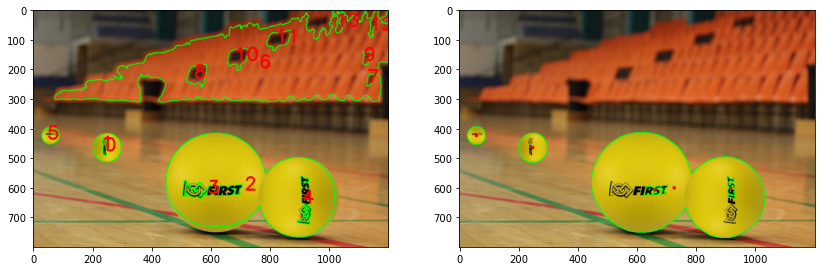

In [8]:
#higher to lessen the amount of small shapes
minArea = 600
#kernel originally 3, higher if shapes inside of desired shape are outlined, lower if t
kernel = 7
#lowerThreshold originally 127, adjust if desired shape is not outlined correctly
#Higher if outline too big in numbered image, lower if too small
lowerThreshold = 187
upperThreshold = 255
#lower if outline in test image is too big, higher if too small
outlierSensitivity = 10

#character written on desired shape 
INDEX = 5

#change image address (ex: powercell_ball.jpg)
imgAddress="Lesson5/gym_with_balls.jpg"

OutputText = True
Debug = False

image = mpimg.imread(imgAddress)


img, arr = locateShapes(imgAddress, minArea, kernel, lowerThreshold, upperThreshold, OutputText, Debug)
rng = findHSVColorRange(image, arr, INDEX, kernel, outlierSensitivity)
#Move HSV function to its own kernel

testImg = testRange(image, rng, kernel, minArea)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(testImg)